With the help of the CRISP-six DM's phases, we will take a quick look at the Airbnb activities in Seattle in this project.
1. Business understanding
2. Data understanding
3. Preparing data
4. Modeling data
5. Results evaluation
6. Deployment

# Business Understanding

## What is Airbnb ?

The term "Air Bed and Breakfast" (also known as Airbnb) refers to a service that enables property owners to let out their spaces to tourists searching for a place to stay. Since its founding in 2008, Airbnb has significantly advanced the tourism sector. Based on a peer-to-peer business model, Airbnb enables users to leverage consumer data to tailor and personalize the experience of their visitors. Thus, the rapid development of data analytics is necessary to address a variety of problems from both hosts and passengers.

## What are the questions to answer in this project ?

The following questions will be addressed in this notebook using the Kaggle Seattle Airbnb Open Data:
1. What are the most frequent host confirmations in the listings?
2. What characteristics of various kinds draw visitors to book a homestay?
3. What factors have the biggest impact on the cost of homestays in Seattle?

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import ast
import re
%matplotlib inline

# Data Understanding

## Gather Data

We will begin by importing the given listings dataset:
- listings.csv: full descriptions, host information and average review score of all the Airbnb in Seattle

In [2]:
# Export dataset using pandas
df = pd.read_csv('./dataset/seattle_airbnb/listings.csv')

# Print out the number of rows and columns in the dataset
print('Shape: ', df.shape)

# Print out few samples of the dataset
df.head(5)

Shape:  (3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


We can see that there are 3818 records of 92 features in the listings dataset.

## Asses Data

In [3]:
# The code below displays the dataset's total number of data kinds as well as the number of each type.
df_types = df.dtypes
print(df_types.value_counts())

object     62
float64    17
int64      13
dtype: int64


There are 62 object features, 17 float64 features and 13 int64 features

In [4]:
# The code below prints the dataframe's total null values for each column in decreasing order.
df.isnull().sum().sort_values(ascending=False)

license             3818
square_feet         3721
monthly_price       2301
security_deposit    1952
weekly_price        1809
                    ... 
room_type              0
accommodates           0
bed_type               0
amenities              0
longitude              0
Length: 92, dtype: int64

# **Question 1: What are the most frequent host confirmations in the listings?**

When I look at the listings dataset, the host_verifications column shows me specific details about how the hosts verify their visitors. What are the most popular methods of verification accessible in the Seattle Airbnb dataset? The list of available verification techniques will be generated by the code in the cells below.

## Prepare Data

In [5]:
host_verifications = []
'''
I need to combine all of these strings into a single list because the host_verifications column comprises strings of lists. 
To identify and create lists from a string of lists, I utilized the literal_eval function from the AST (Abstract Syntax Tree) 
third-party library.
'''
host_verifications.extend(
    ast.literal_eval(df['host_verifications'][i]) for i in range(len(df))
)

In [6]:
'''
We had a list of verification techniques listings after running the cell above.
We now need to combine a list of lists into a single list.
'''
flat_host_verifications = []
for sublist in host_verifications:
    if sublist is None:
        continue
    flat_host_verifications.extend(iter(sublist))
# Remove duplicated methods in verification lists to create list of unique verification methods
flat_host_verifications = list(set(flat_host_verifications))

## Analyze and Visualize Data

In [7]:
'''
This function was adapted from the HowToBreakIntoTheField library, 
which was made available for the Notebook + Quiz: How To Break Into the Field in the Introduction to Data Science 
in the Udacity Data Scientist Course. This function counts the number of entries in the host_verifications list that 
contain each host_verification.
'''
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe we gonna search
    col1 - the column name we will look through
    col2 - the column we want to count values from
    look_for - a list of strings we want to search for in each row

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how frequently it shows up
    '''
    new_df = defaultdict(int)
    for value in look_for:
        for index in range(df.shape[0]):
            if value in df[col1][index]:
                new_df[value] += int(df[col2][index])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [8]:
'''
In order to utilize this function appropriately for this project, 
I slightly changed it from Notebook + Quiz: How To Break Into the Field in Introduction to Datascience in Udacity Data Scientist Course.
'''
def clean_and_plot(df, title='Top 10 Most Popular Verification Techniques in the Dataset from the Host', plot=True):
    '''
    INPUT 
        df - a dataframe holding the host_verifications column
        title - string the title of the plot
        axis
        plot - boolean providing whether or not we want a plot
        
    OUTPUT
        verifications_df - a dataframe with the count of total individuals
        Displays a plot of things related to the host_verifications column.
    '''
    # I create a dataframe named verifications, which has lists of verifications as one column and 
    # the count of these verifications lists
    verifications = df['host_verifications'].value_counts().reset_index()
    verifications.rename(columns={'index': 'host_verifications', 'host_verifications': 'count'}, inplace=True)

    # The line of code below used total_count function to count the number of listings that contains 
    # each verification in the verifications list.
    verifications_df = total_count(verifications, 'host_verifications', 'count', flat_host_verifications)

    verifications_df.set_index('host_verifications', inplace=True)
    if plot:
        '''
        To display the proportion of each verification from the most common to the least common, 
        the line of code below generates a bar chart. In order to make the plot clearer, I also raised the default figure size.
        '''
        (verifications_df / verifications_df.sum()).plot(kind='bar', legend=None, figsize=(12, 12))
        plt.title(title)
        plt.ylabel('The percent of verification methods in the listings')
        plt.show();
    return (verifications_df / verifications_df.sum()).reset_index()

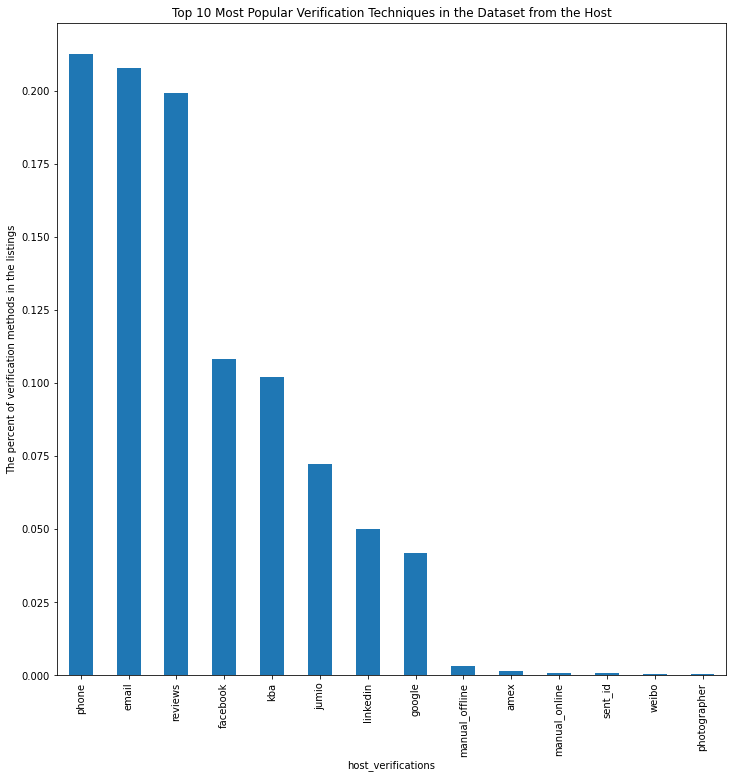

,host_verifications,count
0,phone,0.212703
1,email,0.207934
2,reviews,0.199125
3,facebook,0.108175
4,kba,0.101891
5,jumio,0.072322
6,linkedin,0.049992
7,google,0.041800
8,manual_offline,0.002918
9,amex,0.001403


In [9]:
clean_and_plot(df)

The top 3 prevalent methods of verification in Seattle listings, as seen in the graph and table above, are:
- Phone:            21.27%
- Email:            20.79%
- Reviews:          19.91%

The least common methods of verification applied to ads in Seattle include:
- manual_offline:   2.91%
- amex:             1.4%
- manual_online:    0.07%
- sent_id:          0.05%
- weibo:            0.028%
- photographer:     0.022%

# **Question 2: What characteristics of various kinds draw visitors to book a homestay?**

I see that certain properties, such property_type or room_type, have distinct columns when I look at the dataset. I was intrigued how these elements influence travelers who choose to rent a homestay.

In this question, we'll look at how desirable features are to visitors based on the availability column.
This suggests that when a feature gets more publicly accessible, visitor interest in it declines.

## Prepare Data

In [10]:
# The code below produces the availability_30 column's popularity_30 column, which provides information on the booking percentage for the following 30 days.
df['popularity_30'] = 1 - (df['availability_30']/30)

In [11]:
# Get features that have seperated columns 
feature_type_list = [feature for feature in df.columns if 'type' in feature]
feature_type_list

['property_type', 'room_type', 'bed_type']

## Analyze and Visualize Data

In [12]:
# Unique property types and count of each one
df['property_type'].value_counts().sort_values(ascending=False)

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

We can see that in Seattle, homes and apartments make up more over half of the total number of properties.

In [14]:
# Popularity of different property types for next 30 days
property_type_popularity = df.groupby(['property_type']).mean()['popularity_30']
property_type_popularity = property_type_popularity.sort_values(ascending=False)
property_type_popularity

property_type
Tent               0.800000
Dorm               0.666667
Treehouse          0.666667
Chalet             0.500000
Cabin              0.469841
Apartment          0.456011
Condominium        0.454579
Loft               0.435000
House              0.432583
Townhouse          0.413559
Camper/RV          0.410256
Other              0.301515
Bed & Breakfast    0.257658
Boat               0.250000
Bungalow           0.215385
Yurt               0.066667
Name: popularity_30, dtype: float64

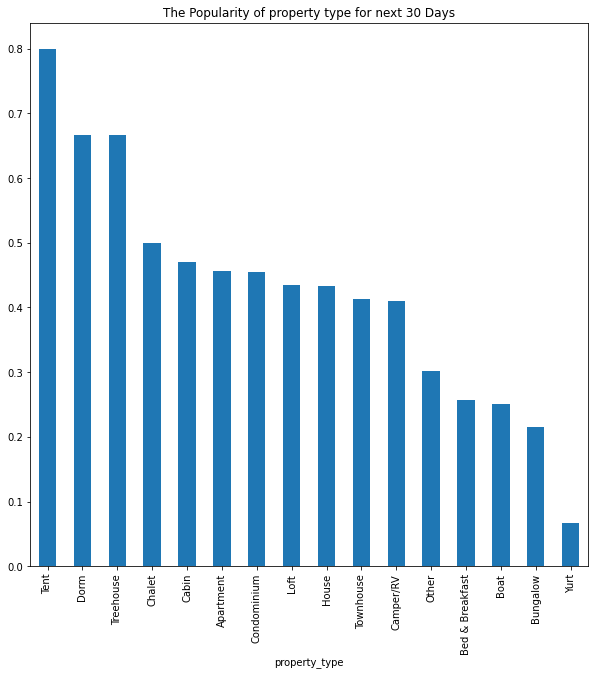

In [15]:
# The code below plots the popularity of different property types for next 30 days
property_type_popularity.plot(kind='bar', legend=None, figsize=(10, 10))
plt.title('The Popularity of property type for next 30 Days');
plt.show()

According to the chart above, a homestay will get more visitors if it contains tents, a dorm, or a treehouse.

In [16]:
# Unique room types and count of each one
df['room_type'].value_counts().sort_values(ascending=False)

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

We can tell that most visitors select a private room or a whole apartment.

In [17]:
# Popularity of different room types for next 30 days
room_type_popularity = df.groupby(['room_type']).mean()['popularity_30']
room_type_popularity = room_type_popularity.sort_values(ascending=False)
room_type_popularity

room_type
Entire home/apt    0.483353
Private room       0.362759
Shared room        0.279202
Name: popularity_30, dtype: float64

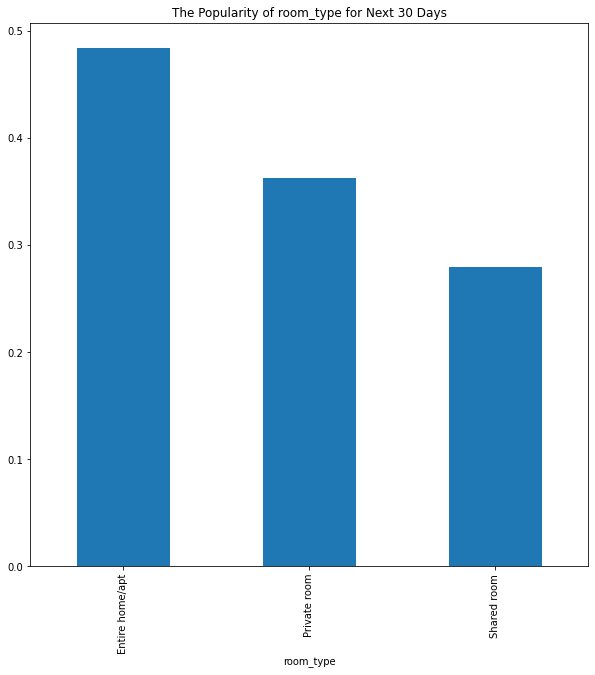

In [18]:
# The code below plots the popularity of different room types for next 30 days
room_type_popularity.plot(kind='bar', legend=None, figsize=(10, 10))
plt.title('The Popularity of room_type for Next 30 Days');
plt.show()

According to the aforementioned figure, individual rooms or shared rooms are less common than complete homes or apartments by around 10%.

In [19]:
# Unique bed types and count of each one
df['bed_type'].value_counts().sort_values(ascending=False)

Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64

When renting a homestay, it is clear that most visitors choose for Real Bed.

In [20]:
# Popularity of different room types for next 30 days
bed_type_popularity = df.groupby(['bed_type']).mean()['popularity_30']
bed_type_popularity = bed_type_popularity.sort_values(ascending=False)
bed_type_popularity

bed_type
Couch            0.579487
Futon            0.451351
Real Bed         0.441564
Airbed           0.419753
Pull-out Sofa    0.310638
Name: popularity_30, dtype: float64

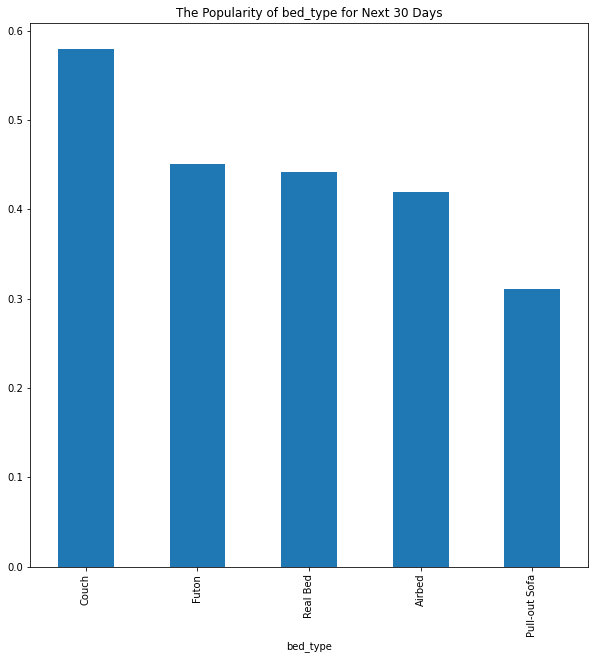

In [21]:
# The code below plots the popularity of different bed types for next 30 days
bed_type_popularity.plot(kind='bar', legend=None, figsize=(10, 10))
plt.title('The Popularity of bed_type for Next 30 Days');
plt.show()

According to the chart above, the homestay will draw more visitors than the others if it has a couch, a futon, or a genuine bed.

In conclusion, a desirable homestay should be a whole house or apartment with a sofa or at the very least a genuine bed, tents, a treehouse, or a dorm room.

# **Question 3: What factors have the biggest impact on the cost of homestays in Seattle?**

## Prepare Data

The dataset contains five distinct sorts of pricing:
- price
- weekly_price
- monthly_price
- security_deposit
- cleaning_fee

In [23]:
# Create list of different types of prices in the dataset
price_list = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee']

# Print the number of missing values in each of the price type
for price_type in price_list:
    print('Missing values in {0}: {1}'.format(price_type, df[price_type].isnull().sum()))

Missing values in price: 0
Missing values in weekly_price: 1809
Missing values in monthly_price: 2301
Missing values in security_deposit: 1952
Missing values in cleaning_fee: 1030


One can notice that some of the ads in the cell code above do not include the weekly price, monthly price, security_deposit, or cleaning_fee. As a result of the bigger sample size, it is better to use the pricing feature.

In [24]:
'''
I created a new dataframe in the code below based on a list of attributes 
I believed are crucial for determining a Seattle listing's pricing.
'''
df_new = df[['property_type', 'room_type', 'bed_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']]
df_new.shape

(3818, 8)

In [25]:
# Check missing values in each feature column
df_new.isnull().sum()[df_new.isnull().sum()>0]

property_type     1
bathrooms        16
bedrooms          6
beds              1
dtype: int64

Eight columns make up the new dataframe, and half of them are missing values. However, I have a plan to complete these columns:
- Because property_type is a categorical column, I'll utilize its mode to fill in the very few missing values.
- There aren't many missing numbers for beds, bathrooms, or bedrooms, so I'll use the mean of each column to fill in the gaps.

In [26]:
# Elimate these symbols from the price values: "$", ","
def process_price(txt):
    '''
    Function that removes special symbols from price values
    INPUT:
    txt - a string of price value that has "$", "," symbols
    
    OUTPUT:
    txt - a string of price value after elimating "$", "," symbols
    '''
    txt, _ = re.subn('[$|,]', '', txt)
    return txt

In [27]:
# Apply the function and change the price data type from string to float
df_new['price'] = df_new['price'].apply(lambda x: process_price(x)).astype(float)

C:\Users\Neo\AppData\Local\Temp\ipykernel_17144\10361177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['price'] = df_new['price'].apply(lambda x: process_price(x)).astype(float)


In [28]:
# Create a list categorical columns from the new dataframe
cat_columns = list(df_new.select_dtypes(include=['object']).columns)
cat_columns

['property_type', 'room_type', 'bed_type']

## Model Data and Evaluation Results

In [31]:
'''
This function I took from Notebook + Quiz: Categorical Variables in Introduction to Datascience in Udacity Data Scientist Course and I have
modified it a little bit to properly use in this project
'''

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    # The lines of code below makes new columns from categorical variables 
    # in order to use these features in machine learning regression algorithm.
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except Exception:
            continue
    return df

In [32]:
'''
This function I took from Notebook + Quiz: Categorical Variables in Introduction to Datascience in Udacity Data Scientist Course and I have
modified it a little bit to properly use in this project
'''

def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    The function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    # Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    # Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    # Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    # Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    # Split into train and test with the ratio 70/30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
    # Apply the linear regression model
    lm_model = LinearRegression(normalize=True)
    
    # Fit the model to the train dataset
    lm_model.fit(X_train, y_train)

    # Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    # Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [33]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_new, 'price', cat_columns, dummy_na=False)

c:\KhoiNXM\Workspace\python_venv\ai_chatbot\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [36]:
print(" The rsquared on the training dataset: {}\n The rsquared on the test dataset: {}.".format(train_score, test_score))

 The rsquared on the training dataset: 0.5269091529139549
 The rsquared on the test dataset: 0.5591501319950756.


In [37]:
'''
This function I took from Notebook + Quiz: Putting It All Together in Introduction to Datascience in Udacity Data Scientist Course and I have
modified it a little bit to properly use in this project. This function is used to see the coefficients of the model
'''

def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [38]:
# Coefficients of the model.
coef_df = coef_weights(lm_model.coef_, X_train).reset_index(drop=True)
coef_df

,est_int,coefs,abs_coefs
0,property_type_Boat,135.991849,135.991849
1,room_type_Shared room,-62.365397,62.365397
2,property_type_Camper/RV,58.727952,58.727952
3,property_type_Dorm,-42.367606,42.367606
4,property_type_Tent,-38.403647,38.403647
5,room_type_Private room,-36.983398,36.983398
6,bathrooms,33.289887,33.289887
7,bedrooms,29.028951,29.028951
8,property_type_Treehouse,24.357420,24.357420
9,property_type_Loft,21.634089,21.634089


We may observe from the table above that:

- Boat property tends to have the greatest impact on the cost of a homestay.

- The price of a homestay is somewhat influenced by the number of bathrooms and bedrooms.

- When renting a homestay, people are unlikely to share a room with others, which would negatively impact the cost of a homestay.


# Conclusion

In conclusion, the three questions are answered as follows:
1. The most popular ways for hosts to respond to their guests are through phone, email, and reviews.
2. A desirable homestay should be a whole house or apartment with a sofa or at the very least a genuine bed, as opposed to tents, a treehouse, or a hostel.
3. The price of a homestay is most significantly influenced by the presence of boats, bathrooms, and bedrooms.